## 批量过滤收集图片一小块区域的信息产生边缘信息
## 在用批量过滤器扫过边缘信息产生高层结构
## 边缘信息画出细节特征，再过滤一次，产生全图像的信息
## 然后丢如全联接层，看到分类结果

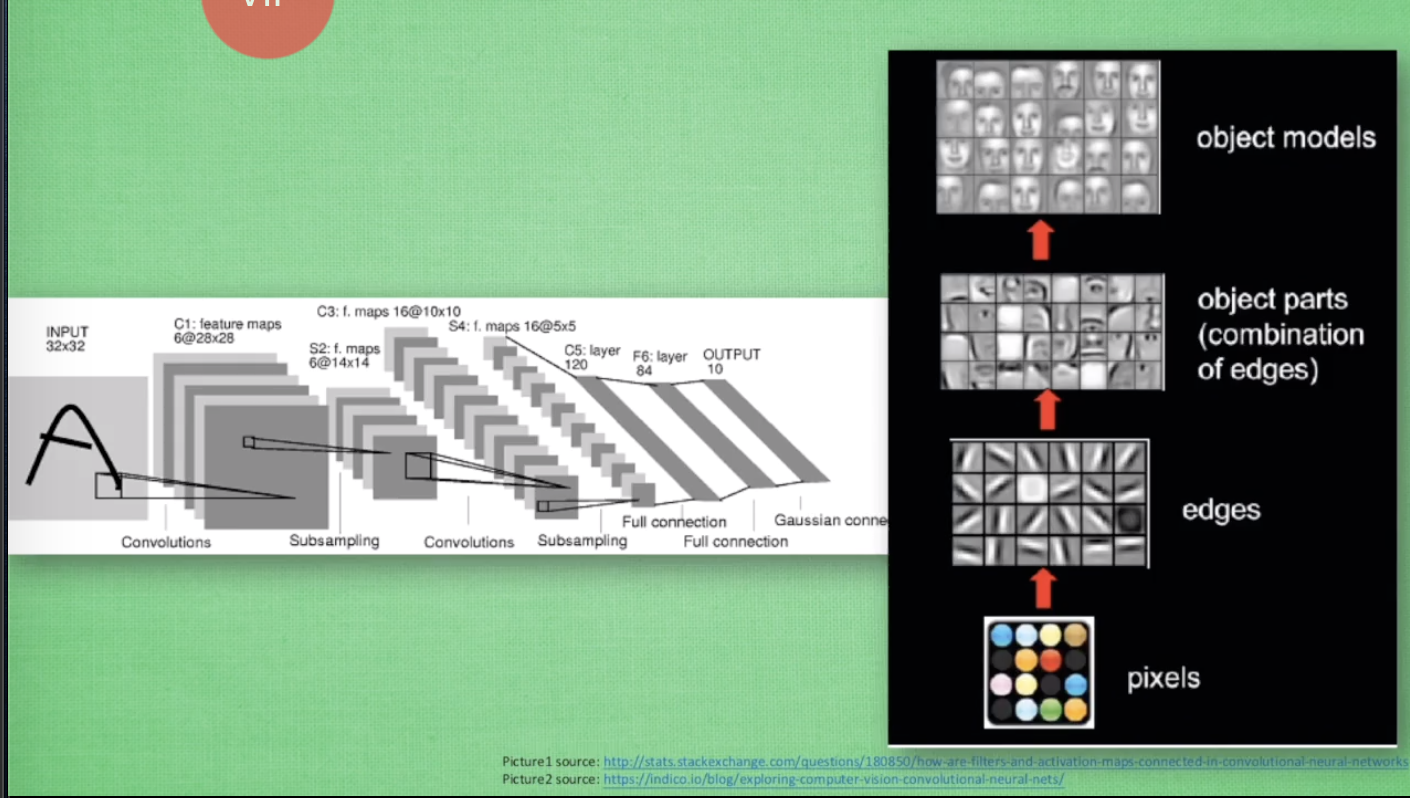

## 照片当中也有长宽高
## 如果是黑白照片，高的单位只有1
## 如果是彩色照片，照片的颜色就有红绿蓝三种信息，高的单位为3
## 不断的滑动窗口，就会得到一些高度更高的小块图片，然后再次卷积，高度再次增加，图片的特征就更容易理解
## 然后再嵌入普通神经层，就可以对图片分类了

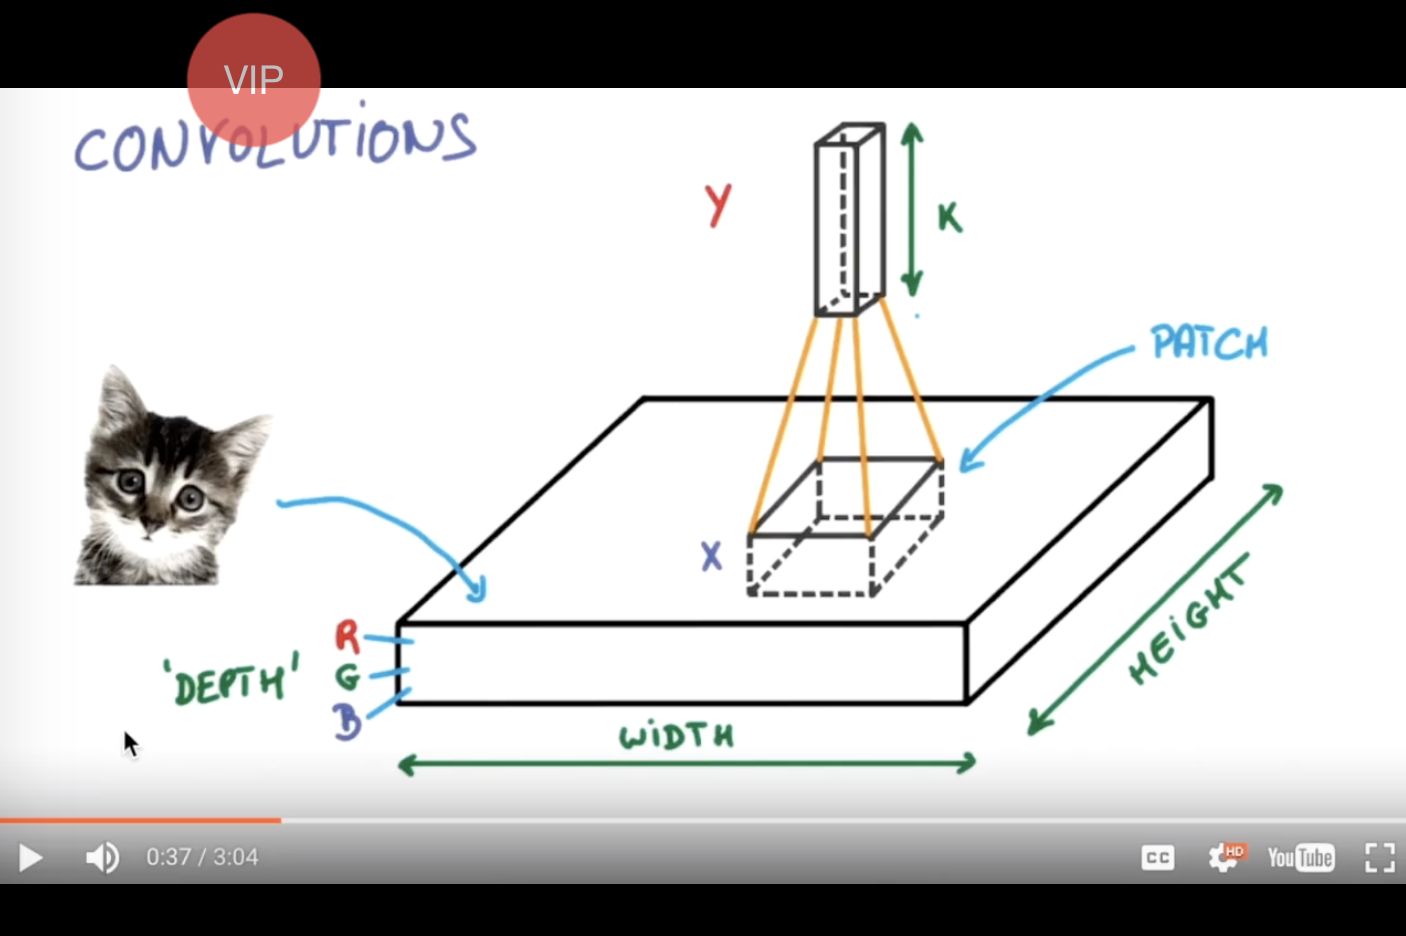

## 池化
## 当神经层经过卷积处理后会丢失信息，所以用池化解决这个问题，压缩的工作就交给池化，这样的附加工作就能很有效的提升准确性

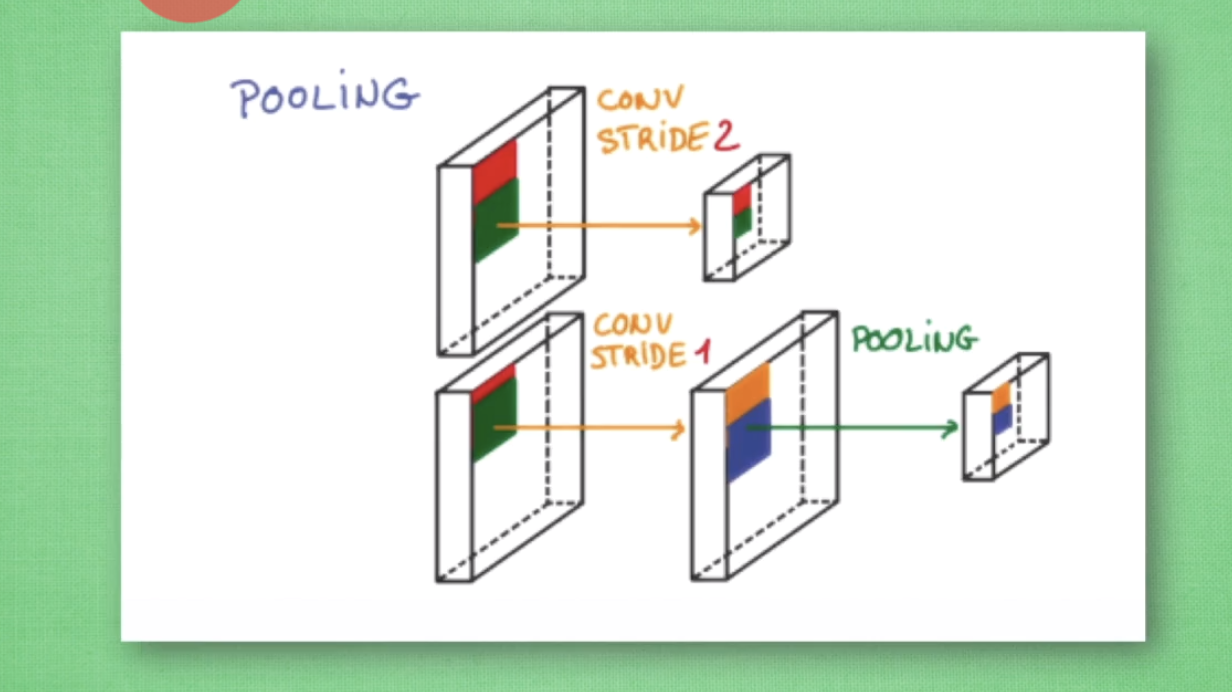

搭建结构1，一般用两层，也可加
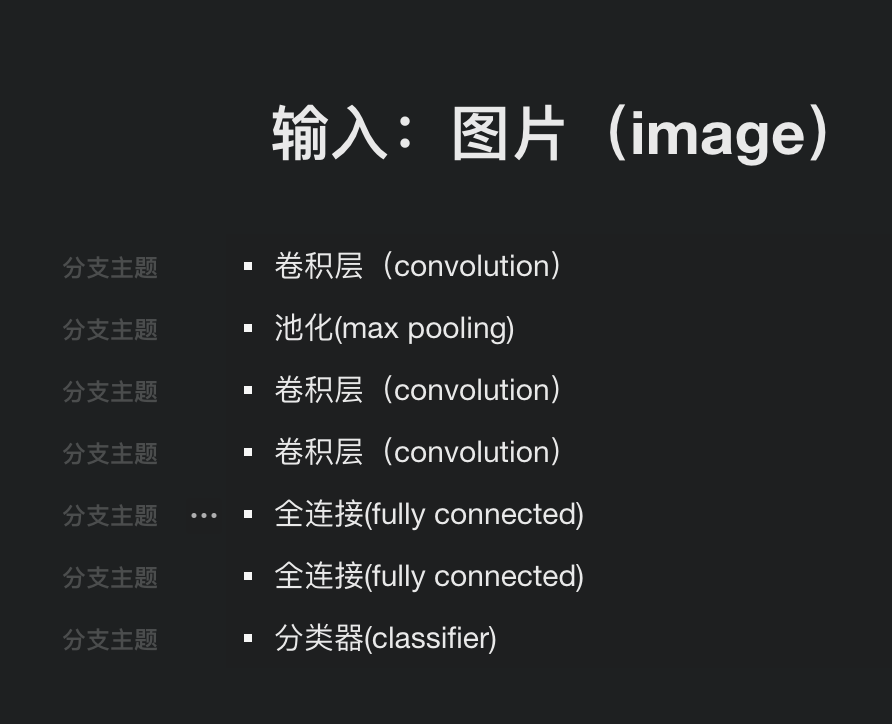

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision #数据库模块
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
# Hyper Parameters
EPOCH = 1 #刷新批量
BATCH_SIZE = 50 #
LR = 0.001
DOWNLOAD_MNIST = False

train_data = torchvision.datasets.MNIST(
    root = './mnist'
    ,train = True
    ,transform = torchvision.transforms.ToTensor()#原始的图片数据是numpy的数据
    ,download = DOWNLOAD_MNIST
)

In [ ]:
train_data.train_data.size(),train_data.train_labels.size()

In [ ]:
plt.imshow(train_data.train_data[0],cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [ ]:
train_loader = Data.DataLoader(dataset=train_data
                               ,batch_size=BATCH_SIZE
                               ,shuffle=True
                               ,num_workers = 2)

In [ ]:
test_data = torchvision.datasets.MNIST(root='./mnist/'
,train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data,dim=1)
,volatile=True).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.test_labels[:2000]

In [ ]:
test_x.type(),test_y.type()

# in_channels(int) – 输入信号的通道数
# out_channels(int) – 卷积产生的通道数
# kerner_size(int or tuple) - 卷积核的大小
# stride(int or tuple,optional) - 卷积步长
# padding(int or tuple, optional) - 输入的每一条边补充0的层数
# output_padding(int or tuple, optional) - 输出的每一条边补充0的层数
# dilation(int or tuple, optional) – 卷积核元素之间的间距
# groups(int, optional) – 从输入通道到输出通道的阻塞连接数
# bias(bool, optional) - 如果bias=True，添加偏置
 

# 1|2输入输出计算过程：
# h_in = 128*128
# h_out = 56*56

# 这里h_in指正向卷积输入

# 正向卷积：h_out = (h_in + 2*padding - kernl_size) / stride  +1
# +1是因为除不尽向下取整

# 故转置卷积：h_in = (h_out - 1) * stride + kernl_size - 2*padding + # output_padding

# output_padding，是因为输出与期望输出有偏差，需在下边补0填充

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d( #输入维度 /维度变化->(1,28,28)
                in_channels = 1 #RGB的高度
                ,out_channels = 16 
                ,kernel_size = 5 # 扫描区域设定，5*5
                ,stride = 1 #扫描的的时候跳跃的步长
                ,padding = 2 #扫描的时候将原始图片增加一层帮助图片滑动窗口时候避免超出范围

            ) #卷积层，筛选特征 /维度变化->(16,28,28)
            #padding参数的计算方法
            #if stride = 1,padding = (kernel_size-1)/2
            ,nn.ReLU() #激活函数 /维度变化->(16,28,28)
            ,nn.MaxPool2d(kernel_size=2) #池化层选择特征中2*2范围内最大的值当作特征 /维度变化->(16,14,14)
        ) 

        self.conv2 = nn.Sequential( #/第二层维度变化->(16,14,14)
            nn.Conv2d(
                in_channels = 16 #RGB的高度接收上次一层的维度16
                ,out_channels = 32
                ,kernel_size = 5 # 扫描区域设定，5*5
                ,stride = 1 #扫描的的时候跳跃的步长
                ,padding = 2 #扫描的时候将原始图片增加一层帮助图片滑动窗口时候避免超出范围
        
            ) #卷积层，筛选特征 /第二层维度变化->(32,14,14)

            ## padding参数的计算方法
            ## if stride = 1,padding = (kernel_size-1)/2

            ,nn.ReLU() #激活函数 /第二层维度变化->(32,14,14)
            ,nn.MaxPool2d(kernel_size=2) #池化层选择特征中2*2范围内最大的值当作特征 /第二层维度变化->(32,7,7)
        )
        self.out = nn.Linear(32*7*7,10) #将上面计算结果的三维数据展平成二维

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x) #->(batch,32,7,7)
        x = x.view(x.size(0),-1) #->(batch,32,*7*7)
        output = self.out(x)
        return output


## 定义优化器

In [ ]:
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(),lr=LR)
loss_func = nn.CrossEntropyLoss() #调用交叉熵函数

## 运行网络

In [ ]:
for epoch in range(EPOCH):
    for step,(x,y) in enumerate(train_loader): 
        b_x , b_y = Variable(x) , Variable(y)
        output = cnn(b_x) #载入训练数据
        loss = loss_func(output,b_y) #载入训练标签
        optimizer.zero_grad() #梯度清零
        loss.backward() #反向传播
        optimizer.step() #传入步长
        #打印损失函数变化
        if step % 50 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output,1)[1].data.squeeze()
            accuracy = (pred_y==test_y).numpy().sum()/test_y.size(0)
            print('Epoch:',epoch,'| train loss %4f' % float(loss.data),'| test accuracy:',accuracy,'%')


## 调用模型预测

In [ ]:
test_output = cnn(test_x[:10]) # 传入数据集
pred_y = torch.max(test_output,1)[1].data.numpy().squeeze() # 预测标签结果
print(pred_y,'prediction number')
print(test_y[:10].numpy(),'real number')

### 一些大的注意事项:

#### 1. 刚开始, 先上小规模数据, 模型往大了放, 只要不爆显存, 能用256个filter你就别用128个. 直接奔着过拟合去. 没错, 就是训练过拟合网络, 连测试集验证集这些都可以不用.为什么?

#### 2. Loss设计要合理.+ 一般来说分类就是Softmax, 回归就是L2的loss. 但是要注意loss的错误范围(主要是回归), 你预测一个label是10000的值, 模型输出0, 你算算这loss多大, 这还是单变量的情况下. 一般结果都是nan. 所以不仅仅输入要做normalization, 输出也要这么弄.

#### 3. 观察loss胜于观察准确率准确率虽然是评测指标, 但是训练过程中还是要注意loss的. 你会发现有些情况下, 准确率是突变的, 原来一直是0, 可能保持上千迭代, 然后突然变1. 要是因为这个你提前中断训练了, 只有老天替你惋惜了. 而loss是不会有这么诡异的情况发生的, 毕竟优化目标是loss.

#### 4. 确认分类网络学习充分，分类网络就是学习类别之间的界限. 你会发现, 网络就是慢慢的从类别模糊到类别清晰的. 怎么发现? 看Softmax输出的概率的分布. 如果是二分类, 你会发现, 刚开始的网络预测都是在0.5上下, 很模糊. 随着学习过程, 网络预测会慢慢的移动到0,1这种极值附近. 所以, 如果你的网络预测分布靠中间, 再学习学习.

#### 5. Learning Rate设置合理

#### 6 对比训练集和验证集的loss

#### 7 清楚receptive field（接收域)的大小